In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GenAI functionality in BigQuery
*powered by BigQuery and Gemini*

<table align="left">
<td style="text-align: center">
  <a href="https://colab.research.google.com/github/GoogleCloudPlatform/data-to-ai/blob/main/labs/genai_in_bigquery.ipynb">
    <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
  </a>
</td>
<td style="text-align: center">
  <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fdata-to-ai%2Fmain%2Flabs%2Fgenai_in_bigquery.ipynb">
    <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
  </a>
</td>
<td style="text-align: center">
  <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/data-to-ai/main/labs/genai_in_bigquery.ipynb">
    <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
  </a>
</td>
<td style="text-align: center">
  <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/data-to-ai/blob/main/labs/genai_in_bigquery.ipynb">
    <img src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery Studio logo"><br> Open in BigQuery Studio
  </a>
</td>
<td style="text-align: center">
  <a href="https://github.com/GoogleCloudPlatform/data-to-ai/blob/main/labs/genai_in_bigquery.ipynb">
    <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
  </a>
</table>

## Overview

This notebook showcases the power of multimodal Gemini models and BigQuery vector search for an image analysis use case. We'll explore how these integrated capabilities can be used to enable searching and monitoring of physical assets.

This notebook will highlight:

* Using Gemini for multimodal analysis. Gemini will extract relevant details from images, and identify issues ranging from litter to broken benches, damaged shelters, or other potential safety hazards.
* Using BigQuery SQL for orchestrating image processing. BigQuery will have access to images in Cloud Storage via an object table. It will store Gemini output which comprises both image attributes (structured data) and description (unstructured data) in a native BigQuery table.
* Using a text embedding model to generate vector embeddings from the textual descriptions to semantically represent the images and enable powerful semantic search using natural language.
* Using BigQuery vector search capabilities for efficient retrieval of images, to help identify semantically similar images.
* An approach to creating hybrid searches which combine the results of full text and vector search.

We will use a set of bus stop images to do the analysis. For more details on the use case please refer to [this page](https://github.com/GoogleCloudPlatform/data-to-ai/blob/main/README.md#use-cases).

## Typical architecture

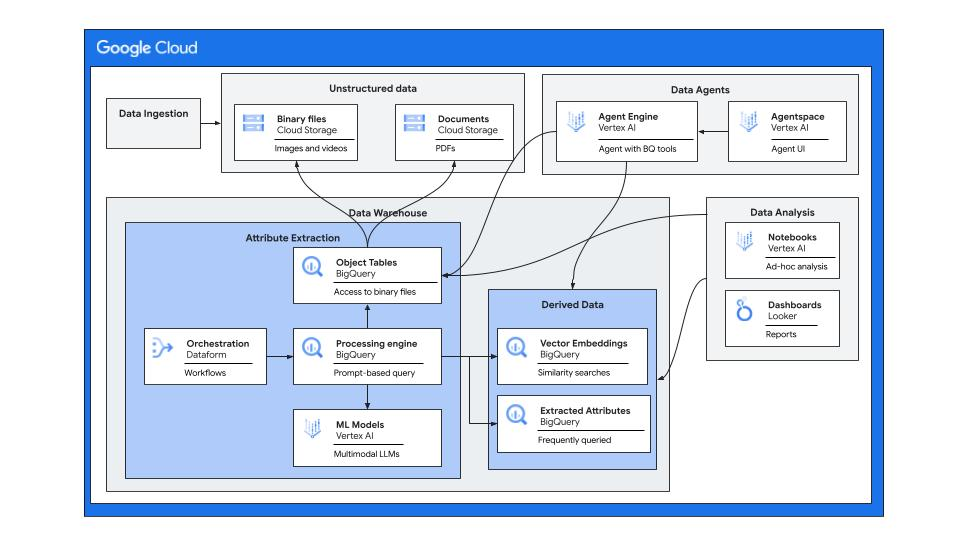


## Getting started

Let's first set some environment variables, including your Google Cloud project ID and the region to deploy resources into:

In [ ]:
import os

PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]
REGION = "us-central1"

BUCKET_NAME = f"{PROJECT_ID}-multimodal"  # Bucket created in subsequent step

### Enable necessary APIs

In [ ]:
!gcloud services enable --project {PROJECT_ID} \
  bigqueryconnection.googleapis.com \
  bigquerystorage.googleapis.com \
  aiplatform.googleapis.com

### Install packages

In [ ]:
%pip install --upgrade --user --quiet \
    google-cloud-aiplatform \
    google-cloud-bigquery

### Import libraries

In [ ]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
from IPython.display import HTML

In [ ]:
# initialize bigquery client

from google.api_core.client_info import ClientInfo

client = bigquery.Client()

# set pandas styling options
# Don't truncate strings in BigQuery query results
pd.set_option('display.max_colwidth', None)

### Define utility functions

We will use the following utility functions, in particular `upload_batch`, to copy images into a given Cloud Storage bucket with specific metadata such as bus stop id and the batch number. This is to simulate the real-world scenario of a transit monitoring solution uploading newly captured bus stop images (tagged with the bus stop ID) and in batches over time e.g. daily.

In [ ]:
import re
from typing import List, Dict, Union
from google.cloud import storage

def parse_gcs_uri(uri: str) -> tuple[str, str]:
    """
    Parse Cloud Storage URI of the form gs://bucket or gs://bucket/path/to/file
    """
    uri = uri.rstrip('/')
    match = re.match(r'gs://([^/]+)(?:/(.*))?', uri)
    if not match:
        raise ValueError(f"Invalid GCS URI format: {uri}")
    bucket_name, path = match.groups()
    return bucket_name, path or ''


def upload_batch(
    batch: List[Dict[str, str]],
    source: str,
    target: str,
    batch_number: Union[int, str]
):
    """
    Copy images from source Cloud Storage location to target with metadata.
    """
    from google.api_core.client_info import ClientInfo
    client = storage.Client()

    source_bucket_name, source_prefix = parse_gcs_uri(source)
    target_bucket_name, target_prefix = parse_gcs_uri(target)

    source_bucket = client.bucket(source_bucket_name)
    target_bucket = client.bucket(target_bucket_name)

    count = 0
    for item in batch:
        try:
            source_path = (
                f"{source_prefix}/{item['path']}" if source_prefix
                else item['path']
            )
            target_path = (
                f"{target_prefix}/{item['path']}" if target_prefix
                else item['path']
            )

            # Get source blob
            source_blob = source_bucket.blob(source_path)
            if not source_blob.exists():
                raise FileNotFoundError(f"Source file {source_path} not found")

            # Download the image bytes
            image_bytes = source_blob.download_as_bytes()

            # Prepare target blob with metadata
            target_blob = target_bucket.blob(target_path)
            target_blob.metadata = {
                "batch_number": f"batch-{batch_number}",
                **{k: str(v) for k, v in item.items() if k != "path"}
            }

            # Upload bytes
            target_blob.upload_from_string(
                image_bytes,
                content_type=source_blob.content_type
            )
            count += 1
            print(f"({count}/{len(batch)}) Uploaded: {item['path']}")

        except Exception as e:
            print("Error processing {item['path']}: {str(e)}")


Let's also define some styling functions to help display dataframes with embedded images.

In [ ]:
# Generate HTML img tag from signed url
def preview_image(uri):
  if pd.notna(uri):
    return f'<img src="{uri}" style="width:300px; height:auto; transition: transform 0.25s ease; border: 1px solid black;" onmouseover="this.style.transform=\'scale(2.5)\';" onmouseout="this.style.transform=\'scale(1.0)\';">'
  else:
    return None

# Highlight rows where resolved is False in red
def highlight_unresolved(row):
    if not row['resolved']:
        return ['background-color: #FFCCCC'] * len(row)
    else:
        return ['background-color: #90EE90'] * len(row)

## Create images dataset

Let's create a Cloud Storage bucket to hold the images:

In [ ]:
from google.cloud import storage
from google.api_core import exceptions

storage_client = storage.Client(project=PROJECT_ID)
try:
    bucket = storage_client.create_bucket(BUCKET_NAME, location=REGION)
    print(f"Bucket {BUCKET_NAME} created")
except exceptions.Conflict:
    # Bucket already exists - return the existing bucket
    bucket = storage_client.bucket(BUCKET_NAME)
    print(f"Bucket {BUCKET_NAME} already exists")
except Exception as e:
    print(f"Error creating bucket {BUCKET_NAME}: {e}")

We'll copy the images from a public bucket with a large set of images to the `sources` folder in the newly created bucket.

In [ ]:
SOURCE_PATH = f"gs://data-to-ai-01-multimodal/sources"
TARGET_PATH = f"gs://{BUCKET_NAME}/sources"

## Set up BigQuery resources

### Create Cloud Resource Connection

Create a Cloud Resource connection:

In [ ]:
!bq mk \
--connection \
--location={REGION} \
--project_id={PROJECT_ID} \
--connection_type=CLOUD_RESOURCE \
multimodal

### Grant necessary IAM permissions

Retrieve the connection service account email address. This connection service account's credentials will be used when making calls to Vertex AI and Cloud Storage.

In [ ]:
import json
import time

i = 0
while i < 3:
  connection_details_json_str = !bq show --format json --connection {PROJECT_ID}.{REGION}.multimodal
  connection_details_dict = json.loads(connection_details_json_str[0])
  CONNECTION_SA_ID = connection_details_dict["cloudResource"]["serviceAccountId"]
  if CONNECTION_SA_ID:
    break

  # it's possible that this command failed, when ran immediately after the previous command
  # this is due to the time it takes the API to be consistent due to async actions on Google Cloud
  time.sleep(10)

  i += 1

if not CONNECTION_SA_ID:
    raise ValueError("No Service Account detected for BQ Connection")

Grant the connection service account Vertex AI User role:

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
  --member='serviceAccount:{CONNECTION_SA_ID}' \
  --role='roles/aiplatform.user' --condition=None \
  --no-user-output-enabled

Grant the connection service account Cloud Storage Object viewer role on the bucket

In [ ]:
!gcloud storage buckets add-iam-policy-binding 'gs://{BUCKET_NAME}' \
    --member='serviceAccount:{CONNECTION_SA_ID}' \
    --role=roles/storage.objectViewer


### Create BigQuery dataset and tables

Create your BigQuery dataset

In [ ]:
!bq mk --location={REGION} --dataset {PROJECT_ID}:multimodal

Create the objects table connected to the Cloud Storage bucket:

In [ ]:
%%bigquery --pyformat
CREATE OR REPLACE EXTERNAL TABLE `multimodal.objects`
WITH CONNECTION `{REGION}.multimodal`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = ['{TARGET_PATH}/*']
)

Create the BigQuery tables that we'll use in the demo:

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `multimodal.image_reports` (
  report_id STRING,
  uri STRING,
  updated TIMESTAMP,
  bus_stop_id STRING,
  number_of_people INT64,
  cleanliness_level INT64,
  safety_level INT64,
  description STRING
);

### Create BigQuery remote models

Now create a remote model which you'll use to analyze the pictures using a Gemini model in Vertex AI. No actual AI model is created in this step; this is
just a "link" to the actual model in Vertex AI.

*NOTE:* this model is only needed when using ML.GENERATE_TEXT function. Newer AI.GENERATE function directly refers to a Vertex AI model.

In [ ]:
%%bigquery --pyformat
CREATE OR REPLACE MODEL `multimodal.gemini_flash_model`
REMOTE WITH CONNECTION `{REGION}.multimodal`
OPTIONS ( endpoint = 'gemini-2.5-flash' )

Let's create a remote model to use Embedding Vertex AI endpoint to later generate vector embeddings over the textual description.

In [ ]:
%%bigquery --pyformat
CREATE OR REPLACE MODEL `multimodal.text_embedding_model`
REMOTE WITH CONNECTION `{REGION}.multimodal`
OPTIONS ( ENDPOINT = 'gemini-embedding-001' )

# Multimodal analysis with Gemini

Bus Stop Image Processing

Let's now look at a batch of pictures. We specify the pictures' filenames as well as the corresponding bus stop IDs:

In [ ]:
batch_1 = [
    {"path": "QD-01.jpg", "stop_id": "1"},
    {"path": "NA-01.jpg", "stop_id": "3"},
    {"path": "QB-01.jpg", "stop_id": "4"},
    {"path": "PA-02.jpg", "stop_id": "5"},
    {"path": "RD-02-dead-leaves.jpg", "stop_id": "6"},
    {"path": "PC-01.jpg", "stop_id": "7"},
    {"path": "NC-02.jpg", "stop_id": "8"},
    {"path": "MD-02.jpg", "stop_id": "9"},
    {"path": "PB-01.jpg", "stop_id": "13"},
    {"path": "ND-02-damaged.jpg", "stop_id": "14"},
    {"path": "QA-02-dirty.jpg", "stop_id": "15"},
    {"path": "SD-03-dirty-damaged.jpg", "stop_id": "16"},
    {"path": "MC-02-dirty-damaged.jpg", "stop_id": "17"},
    {"path": "MA-01.jpg", "stop_id": "18"},
    {"path": "SC-02-broken-glass.jpg", "stop_id": "21"},
    {"path": "UB-01.jpg", "stop_id": "22"},
]

Upload the pictures to the bucket - the bus stop IDs are also attached to the files that land in the bucket:

In [ ]:
upload_batch(
    batch=batch_1,
    source=SOURCE_PATH,
    target=TARGET_PATH,
    batch_number=1
)

Let's see the contents of the object table that is linked to the bucket. You see the list of pictures as well as the bus stop IDs, which are stored as object metadata:

In [ ]:
%%bigquery objects_df
SELECT * FROM `multimodal.objects`
ORDER BY updated;

In [ ]:
objects_df[['uri', 'metadata']]

### Preview images

Let's preview the images. We'll use the corresponding Cloud Storage authenticated urls, then render them in the dataframe table. Note only users who are granted access to view the bucket objects, can access these images.

In [ ]:
%%bigquery batch_df
SELECT
  uri, updated,
  CONCAT("https://storage.mtls.cloud.google.com/", SPLIT(uri, "gs://")[OFFSET(1)]) AS url,
  metadata,
FROM `multimodal.objects`, UNNEST(metadata) AS item
WHERE item.name = "batch_number" AND item.value = "batch-1"

In [ ]:
batch_df['image'] = batch_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(batch_df[['uri', 'image', 'metadata']].to_html(escape=False))

### Analyze images

Now let's extract insights from the pictures. In particular, the query prompts a Gemini image model to assess the state of all bus stops. The provided prompt asks Gemini to rate the cleanliness and safety and to provide a detailed description of the scenes.

There are three BigQuery functions which can call VertexAI models to process binary data - [ML.GENERATE_TEXT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-text), [AI.GENERATE_TABLE](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-table) and [AI.GENERATE](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ai-generate). The last one provides most of the functionality and we are going to use it in this lab.

In [ ]:
%%bigquery --pyformat

INSERT INTO multimodal.image_reports(report_id, uri, updated, bus_stop_id,
  number_of_people, cleanliness_level, safety_level,description)
WITH image_report AS (
  SELECT
    uri,
    updated,
    -- metadata is the special column of an object table; it contains all custom metadata of a Google Storage object
    (SELECT value FROM UNNEST(metadata) WHERE name = 'stop_id') AS bus_stop_id,
    AI.GENERATE(
      ('''
You are a transit supervisor responsible for monitoring bus stops in order to ensure they are safe and clean for everyone.
Analyze these pictures of bus stop images and provide accurate details around safety and cleanliness in and around the bus stop. A bus stop consists of any combination of the following physical assets: a bench, a sign, a shelter, and/or a trash can.

Identify these properties of the image:
* "number_of_people" (Integer): Identify number of people in or around the bus stop.
* "cleanliness_level" (Integer): Rate the general cleanliness of this bus stop. Possible values: 1="dirty and warrants cleaning", 2="clean or mildly clean". The following are examples of cleanliness issues: littering, broken glass, spillage of liquids or oil, ground covered in dead leaves, excessive dirt on benches that would prevent or detract from sitting, unsightly graffiti on the bus stop or surrounding area, disfigured amenities, and anything that would be very unsightly or unreasonably dirty.
* "safety_level" (Integer): Rate the general safety of this bus stop. Possible values: 1="unsafe and warrants attention", 2="safe and doesn't warrant attention". The following are examples of safety issues: broken glass, fallen tree/branches, fire, flooding, electrical hazard, ground covered in dead leaves, dangerous objects, damaged benches/shelters/amenities, slippery ground (e.g. presence of potentially slippery ice on the ground), icicles, low lighting at night, and anything else that could potentially represent a safety hazard for people.
* "description" (String): Provide a detailed textual description of what is in the picture, focusing on cleanliness and safety. This description should explain the cleanliness_level and safety_level scores you provided. This description has a maximum of 200 words. Include any sign of potential vandalism. Do not make things up. Do not make assumptions about the area or the neighborhood where the bus stop is located.
    ''',
      -- "ref" is a special column present in object tables
      OBJ.GET_ACCESS_URL(ref, 'r')),
      -- BigQuery will use the service account created for this connection
      -- The user running the query needs to have permissions to use this connection.
      connection_id => "{PROJECT_ID}.{REGION}.multimodal",
      -- The model end point can be defined in SQL, no need to create a separate BigQuery MODEL.
      -- The endpoint can point to models in the "global" location or to custom models deployed in Vertex AI
      endpoint => 'gemini-2.5-flash',
      -- Any Gemini parameters (except "contents") can be provided here, allowing advanced model execution tuning
      -- NOTE: double curly braces are used here to escape Python formatting. Single braces should be used in SQL
      model_params => JSON '{{"generation_config":{{"thinking_config": {{"thinking_budget": -1}} }} }}',
      -- Structured output can be defined in the SQL. When using ML.GENERATE_TEXT it's necessary to parse JSON to extract values.
      output_schema => 'number_of_people INT64, cleanliness_level INT64, safety_level INT64, description STRING') as llm_response
        FROM `multimodal.objects` WHERE content_type = "image/jpeg")
SELECT
  GENERATE_UUID() as report_id,
  uri,
  updated,
  bus_stop_id,
  -- Here we access the fields provided in the "output_schema" parameter of AI.GENERATE
  llm_response.number_of_people AS number_of_people,
  llm_response.cleanliness_level AS cleanliness_level,
  llm_response.safety_level AS safety_level,
  llm_response.description AS description
FROM image_report;

*Note:* If you run this cell and get an error related to lack of Cloud Storage permissions of the service account associated with the connection - wait a minute or two and retry. It's a race condition related to permission propagation.


Now let's look at the results in the reports table:
* The list of pictures that were just uploaded and the corresponding stop IDs.
* The cleanliness and safety ratings that Gemini provided.
* Number of people detected in the picture
* Textual descriptions of what Gemini could see in the pictures.

In [ ]:
%%bigquery
SELECT * FROM `multimodal.image_reports`;

### Detect and prioritize incidents

Now we can work with extracted image attributes and the free text image description.

This query uses the extracted image attributes to identify bus stops which most likely require maintenance.

In [ ]:
%%bigquery

SELECT
    bus_stop_id, cleanliness_level, safety_level, description,uri
  FROM multimodal.image_reports
  WHERE cleanliness_level <= 1 OR safety_level <= 1

There are quite a few stops that need attention. Here's how we can use a new BigQuery AI function to prioritize which one is urgent. (Note: AI.SCORE function may not be yet available in your project and this query might fail).

In [ ]:
%%bigquery --pyformat

SELECT
  # Prompt example - not well tuned, but it gives an idea
  AI.SCORE(CONCAT("""On the scale 1 to 10, rate the maintenance need of a bus stop based on the description below.
                    Most important is to address safety hazards: broken glass, broken benches, ice.
                    Then rate by the need to remove graffiti, excessive garbage and peeling paint. Description: """, description),
    # The function can be further customized by providing "model_params" which can control Gemini's processing
    connection_id => "{PROJECT_ID}.{REGION}.multimodal") AS score,
    bus_stop_id, cleanliness_level, safety_level, description,uri
  FROM multimodal.image_reports
  -- Prefilter the records to exclude the records which don't have obvious problems
  WHERE cleanliness_level <= 1 OR safety_level <= 1
  ORDER BY score DESC


*Note:* In the next lab you will be able to use an agent to help you prioritize maintenance of bus stops.

# Semantic similarity search

### Generate vector embeddings of the image descriptions

Let's generate embeddings for image reports, specifically using the textual description field, so we can do semantic search

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `multimodal.image_reports_vector_db` AS (
SELECT
  report_id, uri, bus_stop_id, content as description,
  cleanliness_level, safety_level,
  ml_generate_embedding_result AS embedding,
  ml_generate_embedding_status AS status
FROM
  ML.GENERATE_EMBEDDING(
    MODEL `multimodal.text_embedding_model`,
    (SELECT * EXCEPT(description), description as content FROM `multimodal.image_reports` WHERE description IS NOT NULL),
    STRUCT('SEMANTIC_SIMILARITY' as task_type)
  )
);

### Build vector index

The next query will most likely fail because the vector index needs a certain number of rows to be created. But the following queries will function correctly even if the index is not created, and you can always create the index later to improve the performance of the vector searches.

In [ ]:
%%bigquery
CREATE VECTOR INDEX index_ivf ON `multimodal.image_reports_vector_db`(embedding)
STORING (report_id, uri, bus_stop_id, description, cleanliness_level, safety_level)
OPTIONS (index_type = 'IVF', distance_type = 'COSINE')

### Define search helper function

Let's define this utility function for semantic search. This function generates the text embedding for the test query using the same `text_embedding_model` (and same task type), then runs the `VECTOR_SEARCH` query against the base table of embeddings for the vectors, that is `image_reports_vector_db` table. It then appends the authenticated url link to preview the results including the image.

In [ ]:
def run_semantic_search(query:str):
  escaped_query = query.replace("'", "''").replace("\\", "\\\\")

  search_terms_embeddings_query = f"""
    SELECT
      query.content AS search, distance,
      base.report_id, base.bus_stop_id, base.uri, base.description,
      CONCAT("https://storage.mtls.cloud.google.com/", SPLIT(base.uri, "gs://")[OFFSET(1)]) AS url,
      base.cleanliness_level, base.safety_level
    FROM
      VECTOR_SEARCH(
        TABLE `multimodal.image_reports_vector_db`,
        'embedding',
        (
          SELECT * FROM ML.GENERATE_EMBEDDING(
          MODEL `multimodal.text_embedding_model`,
          (
            SELECT '{escaped_query}' AS content
          ),
          STRUCT('SEMANTIC_SIMILARITY' as task_type))
        ),
        top_k => 5,
        distance_type => 'COSINE'
      )
  """

  return client.query(search_terms_embeddings_query).to_dataframe()

### Search for bus stops which have broken glass

In [ ]:
search_results_df = run_semantic_search('broken glass')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['report_id', 'uri', 'distance', 'image', 'description']].to_html(escape=False))

### Search for litter around bus stops

If you read the image descriptions, you will notice that not all of the image descriptions contain the word "litter" even when it is present. But the query below will return those bus stops anyway. This is the power of semantic search compared to using the SEARCH() function which finds the actual word occurrences in the description.

In [ ]:
search_results_df = run_semantic_search('litter')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['bus_stop_id', 'uri', 'distance', 'image', 'description']].to_html(escape=False))

**Notes:** Be aware that unlike the SEARCH() function, vector searches will always return results, even if there is no real match. When building applications based on vector searches additional testing  needs to be done to determine the threshold of the "distance" value which indicates that the result is too far away in the vector space and should not be returned. A typical way to do that is to add a WHERE or HAVING clause to filter out the results which are greater than the threshold.

## Hybrid search

Let's do keyword search alongside semantic search to get even more targeted results. The following helper function `run_hybrid_search` accepts a query string (for semantic search) and a keyword string (for full-text search). The keyword search is applied as a pre-filter in the vector search.

In [ ]:
def run_hybrid_search(query:str, keyword:str):
  escaped_query = query.replace("'", "''").replace("\\", "\\\\")
  escaped_keyword = keyword.replace("'", "''").replace("\\", "\\\\")

  search_terms_embeddings_query = f"""
    SELECT
      query.content AS search,
      base.report_id, base.bus_stop_id, base.uri,
      CONCAT("https://storage.mtls.cloud.google.com/", SPLIT(base.uri, "gs://")[OFFSET(1)]) AS url,
      base.description, distance
    FROM
      VECTOR_SEARCH(
        (SELECT * FROM `multimodal.image_reports_vector_db` WHERE SEARCH(description, '`{escaped_keyword}`')),
        'embedding',
        (
          SELECT * FROM ML.GENERATE_EMBEDDING(
          MODEL `multimodal.text_embedding_model`,
          (
            SELECT '{escaped_query}' AS content
          ),
          STRUCT('SEMANTIC_SIMILARITY' as task_type))
        ),
        top_k => 3,
        distance_type => 'COSINE'
      )
    ORDER BY distance ASC
  """

  return client.query(search_terms_embeddings_query).to_dataframe()

Let's imagine there were reports of vandalism. In this case, we could search for any unsafe bus stop **and** the keyword `vandalism`.

In [ ]:
search_results_df = run_hybrid_search('unsafe bus stop', 'vandalism')
search_results_df

search_results_df['image'] = search_results_df['url'].apply(preview_image)

# Display the DataFrame with embedded images
HTML(search_results_df[['bus_stop_id', 'uri', 'distance', 'image', 'description']].to_html(escape=False))

### Multimodal vector embeddings of images

In the previous section we showed how to build vector embeddings of text description. Another way to do semantic searches is to create [multimodal vector embeddings](https://cloud.google.com/bigquery/docs/generate-multimodal-embeddings) of the images themselves.

**Note:** it's hard to show the power of hybrid searches and different ways to design them on this very small sample of data. Please see [this section of the GitHub repo](https://github.com/GoogleCloudPlatform/data-to-ai/blob/main/README.md#hybrid-search) for a more in-depth discussion on how to create a ranked hybrid search system. That repo shows an example of using a hybrid search combining text and multimodal embeddings and full text search.

# Challenge

This notebook demonstrated the typical sequence of steps required to use BigQuery SQL to process images and enable searching images using Gemini multimodal models. Find another use case and see how you can adjust the code in this notebook to process binary data. Here are some public datasets which can be useful:
* Invoices in PDF format: gs://cloud-samples-data/documentai/Custom/Invoices
* Cymbal Pet Store product images: gs://cloud-samples-data/bigquery/tutorials/cymbal-pets/images

Note: be mindful of the amount of data you are going to process. For demo purposes, define an object table which only consists of several dozen files rather than the whole folder (you can do that by either listing each file explicitly when defining the object table or by providing a wildcard which will only select the files you need).

# Cleanup

In [ ]:
# Delete BigQuery dataset. Uncomment and run the command below if you want to delete the BigQuery set.
# from google.cloud import bigquery
# Do this only if the dataset is created for this demo.
# dataset = f"{PROJECT_ID}.multimodal"
# dataset_object = bigquery.Dataset(dataset)
# client.delete_dataset(dataset_object, delete_contents=True, not_found_ok=True)

